First mount your google drive to this collab script, in order to read in the dataset an other things

In [85]:
#Mount Drive

Next, we will import the necessary modules which are:

- pandas
- numpy
- matplotlib (pyplot)

In [86]:
#Import the modules using the 'import' command


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Take the data files and process them into a pandas dataframe while also doing all the pre processsing

This is how to intepret the data:
(get from .names file)

In [102]:
#TODO: Add the other data frames, and then combine. Also add collumn names
columnNames = ['Age', 'Sex', 'Chest Pain Type', 'Resting Blood Pressure', 'Cholesterol', 'Fasting Blood Sugar', 'Resting ECG', 'Max Heart Rate', 'Exercise Induced Angina', 'ST Depression', 'Slope of ST Peak', 'Number of Major Vessels', 'Thalassemia', 'Diagnosis']
heartDisease_DataFrame = pd.DataFrame(pd.concat([pd.read_csv('processed_cleveland.data', names=columnNames), pd.read_csv('processed_hungarian.data', names=columnNames), pd.read_csv('processed_switzerland.data', names=columnNames), pd.read_csv('processed_va.data', names=columnNames)])).reset_index().drop('index', axis=1)

#The 'Number of Major Vessels' and 'Thalassemia' collumns are full of NaN's, so lets drop it completely
heartDisease_DataFrame = heartDisease_DataFrame.drop(['Number of Major Vessels', 'Thalassemia'], axis=1)

#Replace the ? for NaN values and then accordingly fix all the NaNs
heartDisease_DataFrame = heartDisease_DataFrame.replace('?', np.nan).astype('float')

heartDisease_DataFrame['Resting Blood Pressure'] = heartDisease_DataFrame['Resting Blood Pressure'].fillna(heartDisease_DataFrame['Resting Blood Pressure'].mean())
heartDisease_DataFrame['Cholesterol'] = heartDisease_DataFrame['Cholesterol'].fillna(heartDisease_DataFrame['Cholesterol'].mode().values[0])
heartDisease_DataFrame.dropna(subset=['Fasting Blood Sugar'], inplace=True)
heartDisease_DataFrame['Resting ECG'] = heartDisease_DataFrame['Resting ECG'].fillna(heartDisease_DataFrame['Resting ECG'].mode().values[0])
heartDisease_DataFrame['Max Heart Rate'] = heartDisease_DataFrame['Max Heart Rate'].fillna(int(heartDisease_DataFrame['Max Heart Rate'].mean()))
heartDisease_DataFrame['Exercise Induced Angina'] = heartDisease_DataFrame['Exercise Induced Angina'].fillna(heartDisease_DataFrame['Exercise Induced Angina'].mode().values[0])
heartDisease_DataFrame['ST Depression'] = heartDisease_DataFrame['ST Depression'].fillna(heartDisease_DataFrame['ST Depression'].mode().values[0])
heartDisease_DataFrame.dropna(subset=['Slope of ST Peak'], inplace=True)
heartDisease_DataFrame['Cholesterol'].replace(to_replace = 0.0, value = heartDisease_DataFrame['Cholesterol'].mean(), inplace=True)


heartDisease_DataFrame.head()

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope of ST Peak,Diagnosis
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0


Next, use SciKitLearn to make a test-train split of your data.

In [103]:
#Import those nessesary to do the learning
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

#Store the 'Diagnosis', the indep. variable Y, in a variable and drop the 'diagnosis' column from the main dataframe
diagnosis = heartDisease_DataFrame['Diagnosis']
heartDisease_DataFrame.drop(['Diagnosis', 'Sex', 'Chest Pain Type', 'Fasting Blood Sugar', 'Resting ECG', 'Exercise Induced Angina', 'Slope of ST Peak'], axis=1, inplace=True)

#Make the train test spilt
symptoms_train, symptoms_test, diagnosis_train, diagnosis_test = train_test_split(heartDisease_DataFrame, diagnosis, test_size=.30, random_state=34)

#For the clenliness of the data, reset the indcies of all the data
symptoms_train.reset_index()
symptoms_test.reset_index()
diagnosis_train.reset_index()
diagnosis_test.reset_index()

symptoms_test.head()

,Age,Resting Blood Pressure,Cholesterol,Max Heart Rate,ST Depression
710,67.0,145.0,213.02214,125.0,0.0
211,38.0,120.0,231.00000,182.0,3.8
760,61.0,120.0,213.02214,80.0,0.0
35,42.0,140.0,226.00000,178.0,0.0
220,41.0,112.0,268.00000,172.0,0.0


Intialize the Lasso Regression model and fit the model

In [104]:
print(heartDisease_DataFrame.to_string())

      Age  Resting Blood Pressure  Cholesterol  Max Heart Rate  ST Depression
0    63.0              145.000000    233.00000           150.0            2.3
1    67.0              160.000000    286.00000           108.0            1.5
2    67.0              120.000000    229.00000           129.0            2.6
3    37.0              130.000000    250.00000           187.0            3.5
4    41.0              130.000000    204.00000           172.0            1.4
5    56.0              120.000000    236.00000           178.0            0.8
6    62.0              140.000000    268.00000           160.0            3.6
7    57.0              120.000000    354.00000           163.0            0.6
8    63.0              130.000000    254.00000           147.0            1.4
9    53.0              140.000000    203.00000           155.0            3.1
10   57.0              140.000000    192.00000           148.0            0.4
11   56.0              140.000000    294.00000           153.0  

In [105]:
lambdaPossibilities = np.arange(0, 1, 0.01)
correspondingLambdaScores = np.array([])

X_train = symptoms_train
X_test = symptoms_test
Y_train = diagnosis_train
Y_test = diagnosis_test


def optimize_lambda(lambdaValue):
  lassoModel= linear_model.Lasso(alpha=lambdaValue)
  lassoModel.fit(X_train, Y_train)

  trainScore = lassoModel.score(X_train, Y_train)
  testScore = lassoModel.score(X_test, Y_test)

  return testScore


for possibleValueOfLambda in lambdaPossibilities:
  correspondingLambdaScores = np.append(correspondingLambdaScores, optimize_lambda(possibleValueOfLambda))


#Find the best lambda value
bestLambda = max(correspondingLambdaScores)
print(lambdaPossibilities[np.where(correspondingLambdaScores == bestLambda)])

lassoModel= linear_model.Lasso(alpha=float(lambdaPossibilities[np.where(correspondingLambdaScores == bestLambda)]))
lassoModel.fit(X_train, Y_train)

bestScore = lassoModel.score(X_test, Y_test)
# bestScore = lassoModel.score(X_train, Y_train)

print("The best value for lambda(alpha) is", lambdaPossibilities[np.where(correspondingLambdaScores == bestLambda)], "because the score is", bestScore)

[0.]
The best value for lambda(alpha) is [0.] because the score is 0.307701815930986


/var/folders/31/4xphck791l990qj7wwmlnqh00000gn/T/ipykernel_40248/3176067982.py:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lassoModel.fit(X_train, Y_train)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.969e+02, tolerance: 5.086e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented 

In [106]:
lassoModel1= linear_model.Lasso(alpha=0)
lassoModel1.fit(X_train, Y_train)

bestScore1 = lassoModel1.score(X_train, Y_train)
bestScore2 = lassoModel1.score(X_test, Y_test)

print("""Train Score: {}
      Test Score: {}
      Non-zero coeffs: {}""".format(bestScore1, bestScore2, lassoModel1.coef_))

Train Score: 0.22576540658515032
      Test Score: 0.307701815930986
      Non-zero coeffs: [ 0.01842659  0.00305022 -0.00066468 -0.01151702  0.29007619]


/var/folders/31/4xphck791l990qj7wwmlnqh00000gn/T/ipykernel_40248/1096833876.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lassoModel1.fit(X_train, Y_train)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.969e+02, tolerance: 5.086e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented 

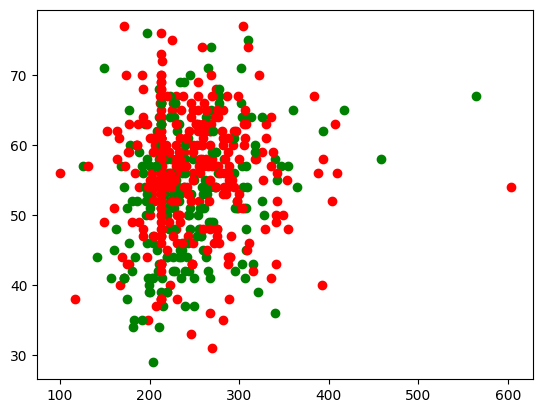

In [128]:
colors = []

x = heartDisease_DataFrame[['Cholesterol']].to_numpy() #Cholesterol, Resting Blood Pressure
y = heartDisease_DataFrame[['Age']].to_numpy() #Age
z = diagnosis.to_numpy()
  
for i in range(len(x)):
    if z[i] >= 1.0:
        colors.append('red')  
    else:
        colors.append('green') 
  
for i in range(len(x)):
    plt.scatter(x[i], y[i], c = colors[i])